# F21DL: Clustering

## Motivation

Growing up, I have always been fascinated with Japanese language and culture. After I was told my wine dataset from Stage 1 would be too easy for subsequent parts, I searched for japanese character datasets and found the Kuzushiji-MNIST dataset. It has 3 datasets, and I chose to work with the one with 49 classes that represent the old Hiragana characters. I skipped the 10 class one because that might be too simple, and skipped the kanji one because I have a preference for hiragana having learned it myself in past.

### Preparation

In [1]:
import os
import sys
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [4]:
# Training data
with np.load("./kmnist/k49-train-imgs.npz") as xTrain:
    xTrain = xTrain['arr_0']

# Training labels
with np.load("./kmnist/k49-train-labels.npz") as yTrain:
    yTrain = yTrain["arr_0"]

# Testing data 
with np.load("./kmnist/k49-test-imgs.npz") as xTest:
    xTest = xTest["arr_0"]

#Testing labels
with np.load("./kmnist/k49-test-labels.npz") as yTest:
    yTest = yTest["arr_0"]

### Exploration

In [5]:
# Credit: HÙNG NGỌC PHÁT, https://www.kaggle.com/hiraki01/hiraganamnist
def showRandom100Examples(X, y, imgdim=28):
    # Generate 100 random indices
    random_idx = np.random.randint(0, X.shape[0], 100)
    random_set = X[random_idx]
    random_set = random_set.reshape(10, 10, imgdim, imgdim)
    # Create 10x10 grid
    fig, ax = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(random_set.shape[0]):
        for j in range(random_set.shape[1]):
            example = random_set[i, j]
            ax[i, j].imshow(example)
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.show()

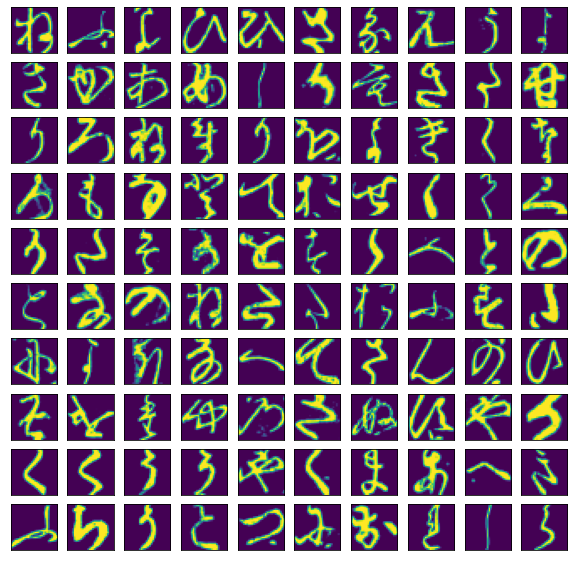

In [6]:
# View 100 random images from dataset
showRandom100Examples(xTrain, 0)

In [7]:
xTrain.shape

(232365, 28, 28)

In [8]:
yTrain.shape

(232365,)

In [9]:
unique_classes = np.unique(yTrain) 
num_class = len(unique_classes)
print(f"Classes: {num_class}")
print(unique_classes)

Classes: 49
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48]


In [10]:
frequency = np.asarray(np.unique(yTrain, True)).T
print(frequency)

[[  0  28]
 [  1  33]
 [  2  30]
 [  3  51]
 [  4   5]
 [  5  69]
 [  6  32]
 [  7   4]
 [  8  34]
 [  9 131]
 [ 10  25]
 [ 11 142]
 [ 12  22]
 [ 13  24]
 [ 14  56]
 [ 15  16]
 [ 16  83]
 [ 17 120]
 [ 18  35]
 [ 19   1]
 [ 20   2]
 [ 21  36]
 [ 22  96]
 [ 23 169]
 [ 24   8]
 [ 25  13]
 [ 26  42]
 [ 27  17]
 [ 28  41]
 [ 29 190]
 [ 30   0]
 [ 31  61]
 [ 32 258]
 [ 33 119]
 [ 34  46]
 [ 35   6]
 [ 36  87]
 [ 37  26]
 [ 38  63]
 [ 39  40]
 [ 40  27]
 [ 41  38]
 [ 42  74]
 [ 43   9]
 [ 44  70]
 [ 45 130]
 [ 46  12]
 [ 47  18]
 [ 48 106]]


In [11]:
np.unique(xTrain)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

### Observations
1. There are 232365 images/instances in the training data.
2. Each image is represented by a 28 * 28 matrix.
3. The above matrix contains greyscale value ranging from 0 to 255.
4. There are a total of 49 classes/characters in this dataset.
5. **Data is imbalanced.**
    1. The character む, represented by index 32 or code U+3080, has a much higher share with 258 observations.
    2. Index such as 19 and 20 have only 1 and 2 observations respectively.
    3. Index 30 has zero observations.

In [12]:
# Flatten the 28*28 matrix so that each image is represented in one row.
xTrain = xTrain.reshape(-1, 28*28)

In [13]:
xTrain.shape

(232365, 784)

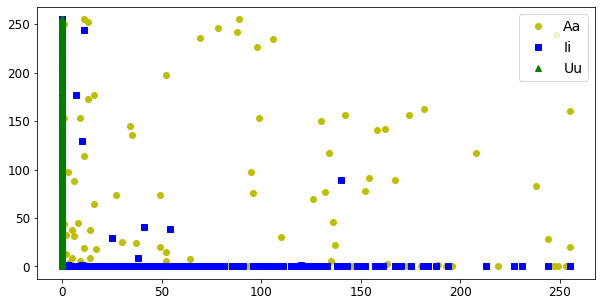

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(xTrain[yTrain==0, 1], xTrain[yTrain==0, 10], "yo", label="Aa")
plt.plot(xTrain[yTrain==1, 1], xTrain[yTrain==1, 10], "bs", label="Ii")
plt.plot(xTrain[yTrain==2, 1], xTrain[yTrain==2, 10], "g^", label="Uu")
plt.legend(fontsize=14, loc='upper right')
plt.show()

# This plot looks weird because the x and y axes are just
# the 2nd and 11th pixel values. Was not sure how else to display it.

**Note:** I am not addressing the data imbalance right now as I do not have time. Might do it at the end as use it for comparison.

## K-Means

In [34]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

In [16]:
# Standardizing data
scaler = StandardScaler()
scaler.fit(xTrain)
xtrain = scaler.fit_transform(xTrain)

In [17]:
kmeans = KMeans(n_clusters=49, random_state=42, init="k-means++")
y_pred = kmeans.fit_predict(xTrain)

In [20]:
y_pred

array([42, 34, 45, ..., 18,  1, 29], dtype=int32)

In [21]:
y_pred is kmeans.labels_

True

In [22]:
kmeans.cluster_centers_

array([[1.07355372e+00, 2.81611570e+00, 5.70702479e+00, ...,
        2.29801653e+01, 9.21322314e+00, 2.04008264e+00],
       [4.44526764e-02, 7.27912576e-02, 7.46434525e-02, ...,
        4.60085201e-01, 2.67271717e-01, 1.75958511e-02],
       [8.72151595e-01, 1.62724874e+00, 2.76445191e+00, ...,
        1.06972895e+01, 4.34204845e+00, 1.05205085e+00],
       ...,
       [1.80316894e-01, 9.70319125e-01, 3.10042401e+00, ...,
        3.24079447e+00, 1.18924347e+00, 3.01048873e-01],
       [2.17361771e-03, 3.32835213e-02, 1.32047276e-01, ...,
        4.93275370e-01, 2.03912512e-01, 6.60236381e-02],
       [4.57599419e-02, 1.47267115e-01, 3.73706192e-01, ...,
        1.15489377e-01, 3.50463047e-02, 2.66453526e-15]])

In [26]:
len(kmeans.cluster_centers_)

49

In [27]:
kmeans.n_iter_

220

In [24]:
# Flatten test data
xTest = xTest.reshape(-1, 28*28)

# Standardizing data
scaler = StandardScaler()
scaler.fit(xTest)
xTest = scaler.fit_transform(xTest)

In [25]:
kmeans.predict(xTest)

array([13, 13, 13, ..., 13, 13, 13], dtype=int32)

### Choosing Number of Clusters: Elbow Method

In [28]:
kmeans_kwargs = {
    "init": "k-means++",
    "max_iter": 300,
    "random_state": 42
}

sse = []
for k in range(1,49):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(xTest)
    sse.append(kmeans.inertia_)

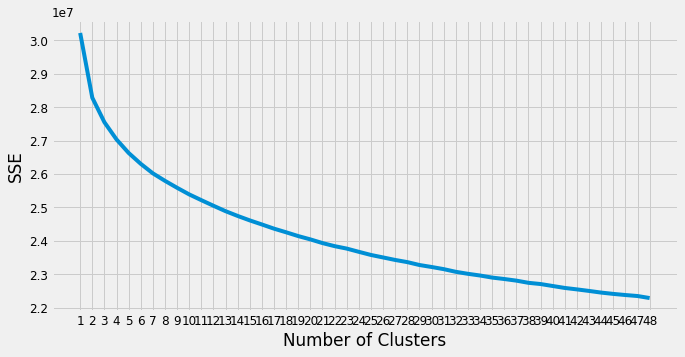

In [32]:
plt.figure(figsize=(10,5))
#plt.style.use("fivethirtyeight")
plt.plot(range(1,49), sse)
plt.xticks(range(1,49))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [35]:
kl = KneeLocator(range(1,49), sse, curve="convex", direction="decreasing")
kl.elbow

11

11 clusters seem to be the elbow point.